In [1]:
import argparse

def args_parser():
    parser = argparse.ArgumentParser()
    # federated arguments
    #RL的训练轮次
    parser.add_argument('--epochs', type=int, default=1000, help="rounds of training")
    
    #嵌入向量的训练轮次
    parser.add_argument('--emb_train_epochs', type=int, default=10, help="rounds of training")
    parser.add_argument('--emb', default=True)
    
    #验证RL和Fedavg哪个更好的验证轮次
    parser.add_argument('--validation_epochs', type=int, default=10, help="rounds of training")
    parser.add_argument('--divide', default=True)
    parser.add_argument('--reset_flag', type=int, default=40, help="reset flag")
    
    #将训练集分为几份
    parser.add_argument('--divide_num', type=int, default=2, help="divide number")
    
    #有多少个local client
    parser.add_argument('--num_users', type=int, default=100, help="number of users: K")
    parser.add_argument('--k', type=int, default=10, help="k")
    
    #每次选多少个local client参与训练
    parser.add_argument('--frac', type=float, default=0.1, help="the fraction of clients: C")
    parser.add_argument('--train_frac', type=float, default=1, help="the fraction of training: C")
    
    parser.add_argument('--collect_ep', type=int, default=1000, help="rounds of training")
    
    #local client自己本地训练的轮次
    parser.add_argument('--local_emb_ep', type=int, default=1, help="the number of local epochs: E")
    parser.add_argument('--local_ep', type=int, default=1, help="the number of local epochs: E")
    parser.add_argument('--local_chosen_ep', type=int, default=2, help="the number of local epochs: E")
    
    #验证环节的local clinet本地训练轮次
    parser.add_argument('--local_validation_ep', type=int, default=1, help="the number of local epochs: E")
    
    #local client本地训练的batchsize
    parser.add_argument('--local_bs', type=int, default=10, help="local batch size: B")
    parser.add_argument('--bs', type=int, default=128, help="test batch size")
    
    #RL的学习率和衰减率
    parser.add_argument('--lr', type=float, default=0.01, help="learning rate (default: 0.01)")
    parser.add_argument('--lr_decay', type=float, default=1, help="lr decay")
    parser.add_argument('--momentum', type=float, default=0.5, help="SGD momentum (default: 0.5)")
    parser.add_argument('--split', type=str, default='user', help="train-test split type, user or sample")

    # model arguments
    
    #使用的client 模型
    parser.add_argument('--model', type=str, default='cnn', help='model name')
    parser.add_argument('--kernel_num', type=int, default=9, help='number of each kind of kernel')
    parser.add_argument('--kernel_sizes', type=str, default='3,4,5',
                        help='comma-separated kernel size to use for convolution')
    parser.add_argument('--norm', type=str, default='batch_norm', help="batch_norm, layer_norm, or None")
    parser.add_argument('--num_filters', type=int, default=32, help="number of filters for conv nets")
    parser.add_argument('--max_pool', type=str, default='True',
                        help="Whether use max pooling rather than strided convolutions")

    # other arguments
    
    #使用的数据集
    parser.add_argument('--dataset', type=str, default='mnist', help="name of dataset")
    
    #数据集的划分是否满足独立同分布
    parser.add_argument('--iid', action='store_true', help='whether i.i.d or not')
    
    #输出的分类个数
    parser.add_argument('--num_classes', type=int, default=10, help="number of classes")
    
    #输入的图片的通道数
    parser.add_argument('--num_channels', type=int, default=1, help="number of channels of imges")
    parser.add_argument('--gpu', type=int, default=-1, help="GPU ID, -1 for CPU")
    parser.add_argument('--stopping_rounds', type=int, default=10, help='rounds of early stopping')
    parser.add_argument('--verbose', action='store_true', help='verbose print')
    parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
    parser.add_argument('--all_clients', action='store_true', help='aggregation over all clients')
    args = parser.parse_args(args=[])
    return args

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
import random
from torchvision import datasets, transforms
from collections import deque
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid, mnist_iid_drl_local_divide, cifar_iid_drl_local_divide, mnist_noniid_drl_local_divide
from models.Update import LocalUpdate
from models.Update_divide import LocalUpdate_divide
from models.Nets import MLP, CNNMnist, CNNCifar, CNNCifarEmb, CNNCifarEmbReverse, CNNMnistEmb, CNNMnistEmbReverse
from models.Fed import FedAvg
# from models.test import test_img

# parse args
args = args_parser()
args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.repeat(1,1,1))])
    dataset_train = datasets.MNIST('./data/mnist/', train=True, download=False, transform=trans_mnist)
    dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    args.iid = True
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    args.iid = True
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

# build model
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
print(net_glob)
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

CNNMnist(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import heapq

# Hyper Parameters
BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.95             # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency

class Net(nn.Module):

    def __init__(self, parameter_dim, action_dim, args):
        super(Net, self).__init__()
        self.args = args
        self.parameter_dim = parameter_dim
        self.action_dim = action_dim

        # N+1 即global的p拼接上所有local的p
        self.fc1 = nn.Linear(parameter_dim, 1000)
        self.fc2 = nn.Linear(1000, action_dim)

    def forward(self, parameters):
        #拼接的p
        x = self.fc1(parameters)
        q = self.fc2(x)
        
        #100维
        return q

class DQN(object):
    def __init__(self, parameter_dim, action_dim, replay_buffer, args):
        self.parameter_dim = parameter_dim
        self.action_dim = action_dim
        self.replay_buffer = replay_buffer
        self.args = args
        self.iter = 0
        #self.noise = utils.OrnsteinUhlenbeckActionNoise(self.action_dim)

        self.eval_net = Net(self.parameter_dim,  
                                 self.action_dim, args).to(args.device)
        self.target_net = Net(self.parameter_dim, 
                                 self.action_dim, args).to(args.device)

        self.learn_step_counter = 0                                     # for target updating
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), 0.01)
#         self.loss_func = F.smooth_l1_loss
         
    #选q最大的local，直接赋值给global，只用一个local参与训练的目的是加快训练
    def choose_action_train(self, parameters):
        q = self.eval_net.forward(parameters)
        action = q.detach().numpy()[0][0].tolist().index(max(q.detach().numpy()[0][0]))
        #这是索引
        print(action)
        return action
    
    #选q最大的10个local，再将它们的q用softmax变成权值
    def choose_action_run(self, parameters):
        q = self.eval_net.forward(parameters)
        #l是q的列表形式
        l = q.detach().numpy()[0][0].tolist()
        
        #最大的k个q值
        topk = heapq.nlargest(int(self.args.frac * self.args.num_users), l)
        
        #找索引
        choice = []
        for i in topk:
            choice.append(l.index(i))
        
        #算权值
        topk_sum = np.sum(topk)
        for i in range(len(topk)):
            topk[i] /= topk_sum
        action = topk
        
        #softmax
#         action = F.softmax(torch.Tensor(topk),0)
        print(action)
        return choice, action

    def optimize(self):
        """
        Samples a random batch from replay memory and performs optimization
        :return:
        """
        s1,a1,r1,s2 = self.replay_buffer.sample(5)
#         print(s1)
#         print(a1)
#         print(r1)
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net.forward(s1) # shape (batch, 1)
        q_eval = q_eval.gather(1,a1.unsqueeze(1)).squeeze()
        
        q_next = self.target_net(s2).detach()     # detach from graph, don't backpropagate
        q_next, a_next = q_next.max(1)
        q_target = r1 + GAMMA * q_next  # shape (batch, 1)
        loss = F.smooth_l1_loss(q_eval.float(), q_target.float())

        
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()
#         self.soft_update(self.target_net, self.eval_net, 0.001)        

In [4]:
class MemoryBuffer: # MemoryBuffer类实现的功能：buffer内采样，往buffer里塞（sars）

    def __init__(self, size):
        self.buffer = deque(maxlen=size) #buffer设置为双端队列
        self.maxSize = size
        self.len = 0
        
    def state_reco(self, s):
        s_1 = [i[0] for i in s]
        s_2 = [i[1] for i in s]
        s_3 = [i[2] for i in s]
        return [torch.cat(s_1),torch.cat(s_2),torch.cat(s_3)]

    def sample(self, count):
        """
        samples a random batch from the replay memory buffer
        :param count: batch size
        :return: batch (numpy array)
        """
        batch = []
        count = min(count, self.len)
        batch = random.sample(self.buffer, count) # 随机取样

        s_arr = torch.cat([arr[0] for arr in batch],1)
        a_arr = torch.tensor([arr[1] for arr in batch])
        r_arr = torch.tensor([arr[2] for arr in batch]).reshape(-1,1)
        s1_arr = torch.cat([arr[3] for arr in batch],1)

        return s_arr, a_arr, r_arr, s1_arr

    def len(self):
        return self.len

    def add(self, s, a, r, s1):
        """
        adds a particular transaction in the memory buffer
        :param s: current state
        :param a: action taken
        :param r: reward received
        :param s1: next state
        :return:
        """
        transition = (s,a,r,s1)
        self.len += 1
        if self.len > self.maxSize:
            self.len = self.maxSize
        self.buffer.append(transition)

In [5]:
#每个local的每一层在emb之后拼接起来，再乘以(100+1)，或者用均值。分别对应是400和100
parameter_dim = (args.num_users+1) * 100
action_dim = args.num_users
print(parameter_dim)

10100


In [6]:
layer_dict = {}
layer_name = []
count = 0
for name in w_glob.keys():
    if count % 2 == 0:
        layer_name.append(name.split('.',1)[0])
    count += 1
    
for i in layer_name:
#     layer_dict[i] = CNNCifarEmb(torch.cat([w_glob[i+'.weight'].reshape(1,-1), w_glob[i+'.bias'].reshape(1,-1)], 1).numel())
    layer_dict[i] = CNNMnistEmb(torch.cat([w_glob[i+'.weight'].reshape(1,-1), w_glob[i+'.bias'].reshape(1,-1)], 1).numel())
# emb_reverse = CNNCifarEmbReverse(args)
emb_reverse = CNNMnistEmbReverse(args)
# print(w_glob[i+'.weight'].reshape(1,-1).numpy()[0])

# print(w_glob[i+'.bias'].numpy())

optimizer = torch.optim.Adam([
    {'params':layer_dict[layer_name[0]].parameters()},
    {'params':layer_dict[layer_name[1]].parameters()},
    {'params':layer_dict[layer_name[2]].parameters()},
    {'params':layer_dict[layer_name[3]].parameters()},
#     {'params':layer_dict[layer_name[4]].parameters()},
    {'params':emb_reverse.parameters()}
] ,0.01)

for iter in range(args.emb_train_epochs):
    idxs_users = np.random.choice(range(args.num_users), 100, replace=False)
    
    for idx in idxs_users:
#         local = LocalUpdate_divide(args=args, dataset=dataset_train, idxs=dict_users[0][idx])
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
#         w, loss, loss_list = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        for i in layer_name:
            if i == 'conv1':
                emb_feature = layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1).to(args.device))
            else:
                emb_feature += layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1).to(args.device))
        avg_emb_feature = emb_feature/4
        transform_w = emb_reverse.forward(avg_emb_feature)
        loss_w = [sum((w[i].reshape(1,-1) - transform_w[i].reshape(1,-1)) ** 2) for i in w_glob.keys()]
        loss_avg = 0
        loss_check_dict = {}
        for i in range(len(loss_w)):
            loss_avg += sum(loss_w[i])/len(loss_w[i])
            loss_check_dict[len(loss_w[i])] = loss_w[i]
            if loss_avg.item() > 3.0:
                print('len:{},w:{}'.format(len(loss_w[i]), loss_check_dict[len(loss_w[i])]))
                print('loss_sum:', loss_avg)
                print('\n***************')
        optimizer.zero_grad()
        loss_avg.backward(retain_graph=True)
        optimizer.step()
        print('epoch:{}, loss_avg:{}'.format(iter, loss_avg))

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch:0, loss_avg:0.11765153706073761
epoch:0, loss_avg:0.15612049400806427
epoch:0, loss_avg:0.16926223039627075
epoch:0, loss_avg:0.12879692018032074
epoch:0, loss_avg:0.13517460227012634
epoch:0, loss_avg:0.08772540837526321
epoch:0, loss_avg:0.05913291871547699
epoch:0, loss_avg:0.03306392952799797
epoch:0, loss_avg:0.03374112769961357
epoch:0, loss_avg:0.03666183724999428
epoch:0, loss_avg:0.030677219852805138
epoch:0, loss_avg:0.03224092721939087
epoch:0, loss_avg:0.0293237566947937
epoch:0, loss_avg:0.046288490295410156
epoch:0, loss_avg:0.024646995589137077
epoch:0, loss_avg:0.034864284098148346
epoch:0, loss_avg:0.03304896876215935
epoch:0, loss_avg:0.029352104291319847
epoch:0, loss_avg:0.03204641863703728
epoch:0, loss_avg:0.02807423286139965
epoch:0, loss_avg:0.027360159903764725
epoch:0, loss_avg:0.02182955853641033
epoch:0, loss_avg:0.026039501652121544
epoch:0, loss_avg:0.1689467579126358
epoch:0, loss_avg:0.025073111057281494
epoch:0, loss_avg:0.024601489305496216
epoch

epoch:2, loss_avg:0.027044083923101425
epoch:2, loss_avg:0.01582355611026287
epoch:2, loss_avg:0.025116994976997375
epoch:2, loss_avg:0.02083859033882618
epoch:2, loss_avg:0.019903333857655525
epoch:2, loss_avg:0.018602021038532257
epoch:2, loss_avg:0.029292967170476913
epoch:2, loss_avg:0.029574625194072723
epoch:2, loss_avg:0.02783844992518425
epoch:2, loss_avg:0.017868153750896454
epoch:2, loss_avg:0.03311767429113388
epoch:2, loss_avg:0.02899814583361149
epoch:2, loss_avg:0.017255766317248344
epoch:2, loss_avg:0.017675848677754402
epoch:2, loss_avg:0.025935040786862373
epoch:2, loss_avg:0.03375428542494774
epoch:2, loss_avg:0.03766346722841263
epoch:2, loss_avg:0.044325824826955795
epoch:2, loss_avg:0.025999797508120537
epoch:2, loss_avg:0.02535869926214218
epoch:2, loss_avg:0.02247733809053898
epoch:2, loss_avg:0.02021358534693718
epoch:2, loss_avg:0.023096725344657898
epoch:2, loss_avg:0.02285434864461422
epoch:2, loss_avg:0.02700837329030037
epoch:2, loss_avg:0.02608666755259037

epoch:3, loss_avg:14.447818756103516
epoch:3, loss_avg:0.03433889523148537
epoch:3, loss_avg:0.06007848307490349
epoch:3, loss_avg:0.0695423111319542
epoch:3, loss_avg:0.04990913346409798
epoch:3, loss_avg:0.08095885813236237
epoch:3, loss_avg:0.12989704310894012
epoch:3, loss_avg:0.15933442115783691
epoch:3, loss_avg:0.16625598073005676
epoch:3, loss_avg:0.08287408202886581
epoch:3, loss_avg:0.037871625274419785
epoch:3, loss_avg:0.06732024252414703
len:250,w:tensor([2.1272e+00, 1.5535e+01, 1.2381e+01, 5.7089e-01, 4.8070e+00, 1.9452e+00,
        1.1866e+00, 4.7518e+00, 2.3588e-03, 2.7088e-01, 2.5425e+00, 9.8655e-01,
        1.0730e+00, 5.8563e-02, 1.7269e-01, 2.1666e+00, 1.1557e+00, 7.3303e-01,
        7.3134e-01, 9.6758e+00, 1.5524e+01, 1.9600e+00, 6.3352e+00, 9.1173e+00,
        4.2635e+01, 3.3359e+00, 4.8691e-03, 1.9493e+00, 8.5579e-02, 6.1648e-01,
        3.2558e-02, 7.0723e+00, 1.1218e+00, 1.1222e+00, 7.0669e-02, 6.2865e+00,
        1.0310e+01, 5.8648e-01, 2.4902e-03, 7.6164e-06,

epoch:3, loss_avg:29.76873207092285
epoch:3, loss_avg:0.5339899659156799
epoch:3, loss_avg:0.8385155200958252
epoch:3, loss_avg:0.8665698170661926
epoch:3, loss_avg:0.5719996094703674
epoch:3, loss_avg:0.22365537285804749
epoch:3, loss_avg:0.0839826837182045
epoch:3, loss_avg:0.2064957320690155
epoch:3, loss_avg:0.41568851470947266
epoch:3, loss_avg:0.5073569416999817
epoch:3, loss_avg:0.4297260046005249
epoch:3, loss_avg:0.21911722421646118
epoch:3, loss_avg:0.07380358874797821
epoch:3, loss_avg:0.07002899050712585
epoch:3, loss_avg:0.18367978930473328
epoch:3, loss_avg:0.2530127167701721
epoch:3, loss_avg:0.22272944450378418
epoch:3, loss_avg:0.15020811557769775
epoch:3, loss_avg:0.08754447102546692
epoch:3, loss_avg:0.0785725936293602
epoch:3, loss_avg:0.10162685811519623
epoch:3, loss_avg:0.1329973340034485
epoch:3, loss_avg:0.10177411139011383
epoch:3, loss_avg:0.08118711411952972
epoch:3, loss_avg:0.06293879449367523
epoch:3, loss_avg:0.08443368226289749
epoch:3, loss_avg:0.10712

epoch:5, loss_avg:0.026787608861923218
epoch:5, loss_avg:0.02199394255876541
epoch:5, loss_avg:0.021833879873156548
epoch:5, loss_avg:0.03173618018627167
epoch:5, loss_avg:0.029743172228336334
epoch:5, loss_avg:0.020397311076521873
epoch:5, loss_avg:0.021688148379325867
epoch:5, loss_avg:0.019113799557089806
epoch:5, loss_avg:0.02561766281723976
epoch:5, loss_avg:0.026842957362532616
epoch:5, loss_avg:0.023107344284653664
epoch:5, loss_avg:0.0386764220893383
epoch:5, loss_avg:0.022374533116817474
epoch:5, loss_avg:0.03448573872447014
epoch:6, loss_avg:0.032405588775873184
epoch:6, loss_avg:0.024789676070213318
epoch:6, loss_avg:0.02291075512766838
epoch:6, loss_avg:0.025056947022676468
epoch:6, loss_avg:0.02115209773182869
epoch:6, loss_avg:0.029216155409812927
epoch:6, loss_avg:0.03404322266578674
epoch:6, loss_avg:0.03394370898604393
epoch:6, loss_avg:0.03845585882663727
epoch:6, loss_avg:0.027736550197005272
epoch:6, loss_avg:0.032433219254016876
epoch:6, loss_avg:0.0244255233556032

epoch:7, loss_avg:0.02338111586868763
epoch:8, loss_avg:0.016840705648064613
epoch:8, loss_avg:0.024840380996465683
epoch:8, loss_avg:0.028746772557497025
epoch:8, loss_avg:0.03975165635347366
epoch:8, loss_avg:0.02925858646631241
epoch:8, loss_avg:0.029707351699471474
epoch:8, loss_avg:0.02214149758219719
epoch:8, loss_avg:0.026620924472808838
epoch:8, loss_avg:0.03282255679368973
epoch:8, loss_avg:0.02751324325799942
epoch:8, loss_avg:0.020535286515951157
epoch:8, loss_avg:0.02649335004389286
epoch:8, loss_avg:0.021418137475848198
epoch:8, loss_avg:0.02924240753054619
epoch:8, loss_avg:0.03362872824072838
epoch:8, loss_avg:0.038606759160757065
epoch:8, loss_avg:0.031401317566633224
epoch:8, loss_avg:0.03226163983345032
epoch:8, loss_avg:0.026493331417441368
epoch:8, loss_avg:0.03173384070396423
epoch:8, loss_avg:0.03464833274483681
epoch:8, loss_avg:0.021564297378063202
epoch:8, loss_avg:0.031065991148352623
epoch:8, loss_avg:0.03712431341409683
epoch:8, loss_avg:0.02490568533539772


In [7]:
replay_buffer = MemoryBuffer(500)
dqn = DQN(parameter_dim, action_dim, replay_buffer, args)

In [8]:
def FedPareto(w, action, choice):
    w_chosen = []
    for i in choice:
        w_chosen.append(w[i])
    w_avg = copy.deepcopy(w_chosen[0])
    for k in w_avg.keys():
        for i in range(0, len(w_chosen)):
            if i==0:
                w_avg[k] = action[i] * w_chosen[i][k]
            else:
                w_avg[k] += action[i] * w_chosen[i][k]
    return w_avg

In [9]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

def test_img(net_g, datatest, args):
    net_g.eval()
    # testing
    test_loss = 0
    correct = 0
    data_loader = DataLoader(datatest, batch_size=args.bs)
    l = len(data_loader)
    for idx, (data, target) in enumerate(data_loader):
        if args.gpu != -1:
            data, target = data, target
        log_probs = net_g(data)
        # sum up batch loss
        test_loss += F.cross_entropy(log_probs, target, reduction='sum').item()
        # get the index of the max log-probability
        y_pred = log_probs.data.max(1, keepdim=True)[1]
        correct += y_pred.eq(target.data.view_as(y_pred)).long().sum()

    test_loss /= len(data_loader.dataset)
    accuracy = 100.00 * correct / len(data_loader.dataset)
    if args.verbose:
        print('\nTest set: Average loss: {:.4f} \nAccuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(data_loader.dataset), accuracy))
    return accuracy, test_loss

In [10]:
# training rl
loss_train = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

loss_save = []
m = max(int(args.frac * args.num_users), 1)
constant = 2
target_acc = 0.99
args.emb = False
dqn = torch.load('dqn_softmax_{}_{}_{}_clientnumber{}_localep{}.pt'.format(args.dataset, args.epochs, args.model, m, args.local_ep))
# dqn = torch.load('dqn_{}_{}_{}_clientnumber{}_localep{}.pt'.format(args.dataset, args.epochs, args.model, m, args.local_ep))

last_replay_data = []
for iter in range(args.epochs):
    if iter==0:
        random_n = 0
        n_weight = []
        while random_n<args.num_users*args.frac:
            n_weight.append(random.random()) # 随机初始化参数
            random_n+=1
        action = random.randint(0,99)

    #重置global参数    
    if iter % args.reset_flag == 0:
        if args.model == 'cnn' and args.dataset == 'cifar':
            net_glob = CNNCifar(args=args).to(args.device)
        elif args.model == 'cnn' and args.dataset == 'mnist':
            net_glob = CNNMnist(args=args).to(args.device)
        elif args.model == 'mlp':
            len_in = 1
            for x in img_size:
                len_in *= x
            net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
        else:
            exit('Error: unrecognized model')  
        
        
    loss_locals = []
    w_locals = []
    p_emb_collect = []
    for i in layer_name:
        if i == 'conv1':
            emb_global = layer_dict[i].forward(torch.cat([net_glob.state_dict()[i+'.weight'].reshape(1,-1), net_glob.state_dict()[i+'.bias'].reshape(1,-1)], 1))
        else:
            emb_global += layer_dict[i].forward(torch.cat([net_glob.state_dict()[i+'.weight'].reshape(1,-1), net_glob.state_dict()[i+'.bias'].reshape(1,-1)], 1))
    p_emb_collect.append(emb_global)
    
    for idx in range(100):
        if idx == action:
            local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx], flag=True)
        else:
            local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
#         if loss != 0:
#             print('local loss:', loss)
        #把parameter转成嵌入
        
        ##########  求均值方式  #######
        for i in layer_name:
            if i == 'conv1':
                emb_feature = layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
            else:
                emb_feature += layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
        
        #分母对应local网络的层数
        avg_emb_feature = emb_feature/4
        
        ##########  拼接方式  ##########
#         for i in layer_name:
#             if i == 'conv1':
#                 cat_emb = layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
#             else:
#                 cat_emb = torch.cat([cat_emb, layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))], 1)
                
        ############ 储存嵌入 ##############
        p_emb_collect.append(avg_emb_feature)
        ############ 储存参数 ##############
        w_locals.append(copy.deepcopy(w))
    p_emb_collect = torch.cat(p_emb_collect,1).unsqueeze(0).to(args.device)
#     print(p_emb_collect)
    action_next = dqn.choose_action_train(p_emb_collect)
    
    ###########  计算当前轮的reward，然后将当前轮的reward添加到上一个replay_data中    
    net_glob.eval()
    global_acc, loss_train = test_img(net_glob, dataset_train, args)
    print(global_acc)
    reward = constant ** (global_acc.numpy()/100 - target_acc) - 1
    loss_save.append(reward)
    
    if len(last_replay_data)==2:
        last_replay_data.append(reward)#r
        last_replay_data.append(p_emb_collect)#s_next
        dqn.replay_buffer.add(last_replay_data[0], last_replay_data[1], last_replay_data[2], last_replay_data[3])
    
    last_replay_data = [p_emb_collect, action_next]#s, a
    action = action_next
    
    # update global weights
#     w_glob = FedAvg(w_locals)
#     w_glob = FedPareto(w_locals, action_next)
    # copy weight to net_glob
    net_glob.train()
    net_glob.load_state_dict(w_locals[action])
    
    
    # print loss
    print('Round {:3d}, Average loss {:.3f}'.format(iter, reward))
#     loss_train.append(-reward)
    
    if iter > 0:
        dqn.optimize()
    if iter % 10 == 0:
#         torch.save(dqn, 'dqn_{}_{}_{}_clientnumber{}_localep{}.pt'.format(args.dataset, args.epochs, args.model, m, args.local_ep))
        torch.save(dqn, 'dqn_softmax_{}_{}_{}_clientnumber{}_localep{}.pt'.format(args.dataset, args.epochs, args.model, m, args.local_ep))
        print("saved")
#     args.lr = max(args.lr*args.lr_decay, 0.001)


flag
44
tensor(11.7467)
Round   0, Average loss -0.454
saved
flag
44
tensor(9.9300)
Round   1, Average loss -0.461
flag
44
tensor(64.9533)
Round   2, Average loss -0.210
flag
44
tensor(82.1650)
Round   3, Average loss -0.110
flag
44
tensor(86.4650)
Round   4, Average loss -0.083
flag
44
tensor(87.0400)
Round   5, Average loss -0.080
flag
21
tensor(87.4500)
Round   6, Average loss -0.077
flag
93
tensor(85.5750)
Round   7, Average loss -0.089
flag
9
tensor(86.7367)
Round   8, Average loss -0.081
flag
70
tensor(85.8133)
Round   9, Average loss -0.087
flag
70
tensor(86.1883)
Round  10, Average loss -0.085
saved
flag
70
tensor(85.8583)
Round  11, Average loss -0.087
flag
10
tensor(86.5917)
Round  12, Average loss -0.082
flag
82
tensor(86.1050)
Round  13, Average loss -0.086
flag
13
tensor(87.9217)
Round  14, Average loss -0.074
flag
85
tensor(89.5517)
Round  15, Average loss -0.063
flag
85
tensor(88.5350)
Round  16, Average loss -0.070
flag
85
tensor(89.1350)
Round  17, Average loss -0.066


flag
9
tensor(80.6867)
Round 148, Average loss -0.119
flag
48
tensor(83.7817)
Round 149, Average loss -0.100
flag
30
tensor(80.5500)
Round 150, Average loss -0.120
saved
flag
30
tensor(80.0700)
Round 151, Average loss -0.123
flag
62
tensor(79.1567)
Round 152, Average loss -0.129
flag
0
tensor(76.5300)
Round 153, Average loss -0.144
flag
76
tensor(73.1750)
Round 154, Average loss -0.164
flag
50
tensor(75.9667)
Round 155, Average loss -0.148
flag
7
tensor(71.5967)
Round 156, Average loss -0.173
flag
7
tensor(81.1183)
Round 157, Average loss -0.117
flag
30
tensor(79.2133)
Round 158, Average loss -0.128
flag
59
tensor(63.9217)
Round 159, Average loss -0.216
flag
88
tensor(9.7367)
Round 160, Average loss -0.461
saved
flag
88
tensor(28.1217)
Round 161, Average loss -0.388
flag
26
tensor(80.4433)
Round 162, Average loss -0.121
flag
26
tensor(80.4750)
Round 163, Average loss -0.121
flag
5
tensor(83.0533)
Round 164, Average loss -0.105
flag
5
tensor(84.8650)
Round 165, Average loss -0.093
flag


flag
28
tensor(88.7450)
Round 297, Average loss -0.069
flag
3
tensor(83.5617)
Round 298, Average loss -0.101
flag
3
tensor(88.5517)
Round 299, Average loss -0.070
flag
29
tensor(89.2167)
Round 300, Average loss -0.066
saved
flag
57
tensor(80.1283)
Round 301, Average loss -0.123
flag
7
tensor(74.9333)
Round 302, Average loss -0.154
flag
3
tensor(87.8683)
Round 303, Average loss -0.074
flag
3
tensor(87.0233)
Round 304, Average loss -0.080
flag
3
tensor(88.5450)
Round 305, Average loss -0.070
flag
3
tensor(90.6183)
Round 306, Average loss -0.056
flag
29
tensor(88.9017)
Round 307, Average loss -0.068
flag
29
tensor(85.5100)
Round 308, Average loss -0.089
flag
98
tensor(76.5350)
Round 309, Average loss -0.144
flag
30
tensor(82.8733)
Round 310, Average loss -0.106
saved
flag
3
tensor(74.5067)
Round 311, Average loss -0.156
flag
3
tensor(84.3467)
Round 312, Average loss -0.097
flag
3
tensor(89.4883)
Round 313, Average loss -0.064
flag
3
tensor(88.0650)
Round 314, Average loss -0.073
flag
29
t

flag
7
tensor(85.3550)
Round 446, Average loss -0.090
flag
7
tensor(87.5633)
Round 447, Average loss -0.076
flag
30
tensor(88.0233)
Round 448, Average loss -0.073
flag
64
tensor(87.)
Round 449, Average loss -0.080
flag
64
tensor(89.1533)
Round 450, Average loss -0.066
saved
flag
64
tensor(88.9050)
Round 451, Average loss -0.068
flag
64
tensor(88.5567)
Round 452, Average loss -0.070
flag
30
tensor(87.7483)
Round 453, Average loss -0.075
flag
7
tensor(89.0483)
Round 454, Average loss -0.067
flag
7
tensor(87.4900)
Round 455, Average loss -0.077
flag
64
tensor(89.3883)
Round 456, Average loss -0.064
flag
64
tensor(90.0983)
Round 457, Average loss -0.060
flag
64
tensor(88.9900)
Round 458, Average loss -0.067
flag
48
tensor(90.1917)
Round 459, Average loss -0.059
flag
7
tensor(88.8450)
Round 460, Average loss -0.068
saved
flag
64
tensor(89.2267)
Round 461, Average loss -0.065
flag
64
tensor(89.6250)
Round 462, Average loss -0.063
flag
30
tensor(89.7217)
Round 463, Average loss -0.062
flag
30

KeyboardInterrupt: 

In [22]:
# fl
#initialize
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
net_glob.train()
w_glob = net_glob.state_dict()


m = max(int(args.frac * args.num_users), 1)
dqn = torch.load('dqn_softmax_{}_{}_{}_clientnumber{}_localep{}.pt'.format(args.dataset, args.epochs, args.model, m, args.local_ep))
constant = 2
target_acc = 0.98
for iter in range(args.validation_epochs):
    if iter==0:
        random_n = 0
        n_weight = []
        while random_n<args.num_users*args.frac:
            n_weight.append(random.random()) # 随机初始化参数
            random_n+=1
        l = list(range(0,100))
        action = random.sample(l, m)
      
    loss_locals = []
    w_locals = []
    p_emb_collect = []
    choice = []
    
    for i in layer_name:
        if i == 'conv1':
            emb_global = layer_dict[i].forward(torch.cat([net_glob.state_dict()[i+'.weight'].reshape(1,-1), net_glob.state_dict()[i+'.bias'].reshape(1,-1)], 1))
        else:
            emb_global += layer_dict[i].forward(torch.cat([net_glob.state_dict()[i+'.weight'].reshape(1,-1), net_glob.state_dict()[i+'.bias'].reshape(1,-1)], 1))
    p_emb_collect.append(emb_global)
    
    for idx in range(100):
        if idx in choice:
            local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx], flag=True)
        else:
            local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        
        #把parameter转成嵌入
        
        ##########  求均值方式  #######
        for i in layer_name:
            if i == 'conv1':
                emb_feature = layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
            else:
                emb_feature += layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
        
        #分母对应local网络的层数
        avg_emb_feature = emb_feature/4
        
        
        ##########  拼接方式  ##########
        for i in layer_name:
            if i == 'conv1':
                cat_emb = layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
            else:
                cat_emb = torch.cat([cat_emb, layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))], 1)
                
        ############ 储存嵌入 ##############
        p_emb_collect.append(avg_emb_feature)
        
        ############ 储存参数 ##############
        w_locals.append(copy.deepcopy(w))
        
    p_emb_collect = torch.cat(p_emb_collect,1).unsqueeze(0).to(args.device)
    choice, action_next = dqn.choose_action_run(p_emb_collect)
    
    ###########  计算当前轮的reward，然后将当前轮的reward添加到上一个replay_data中    
#     net_glob.eval()
    global_acc, loss_train = test_img(net_glob, dataset_train, args)
    reward = constant ** (global_acc.numpy()/100 - target_acc) - 1

    action = action_next
    
    # update global weights
    #fedavg
#     chosen_w = []
#     for i in choice:
#         chosen_w.append(w_locals[i])
#     w_glob = FedAvg(chosen_w)
    
    #ours
    w_glob = FedPareto(w_locals, action_next, choice)
    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)
    
    # print loss
    print('Round {:3d}, Average loss {:.3f}'.format(iter, -reward))
#     loss_train.append(-reward)

#     args.lr = max(args.lr*args.lr_decay, 0.001)

[0.13522605180997774, 0.13113093543615326, 0.10915445079580538, 0.10810005646881045, 0.09496720764244238, 0.09241013202788523, 0.08532814414827238, 0.08215351082241859, 0.08160765298880038, 0.0799218578594342]
Round   0, Average loss 0.471
[0.1464054071168125, 0.13509373123780333, 0.09731170691151551, 0.09617656799766947, 0.09419746065392928, 0.0920803910027495, 0.08722487106152513, 0.08684622894543227, 0.08573764459756913, 0.07892599047499388]
Round   1, Average loss 0.458
[0.14176247172602668, 0.1332077164888295, 0.10507772486789062, 0.09797671041836531, 0.09711169320654259, 0.09132140071519887, 0.08774828167748379, 0.08385428433021862, 0.08202286947047882, 0.07991684709896518]
Round   2, Average loss 0.286
[0.14067156882328952, 0.14019124827552715, 0.10368967915664644, 0.09522990955367919, 0.09257706727497184, 0.09171380095363302, 0.08663293515036292, 0.08497931038930742, 0.08299444885977235, 0.08132003156281015]
Round   3, Average loss 0.114
[0.1449761381488929, 0.13075162235441326

In [23]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

def test_img(net_g, datatest, args):
    net_g.eval()
    # testing
    test_loss = 0
    correct = 0
    data_loader = DataLoader(datatest, batch_size=args.bs)
    l = len(data_loader)
    for idx, (data, target) in enumerate(data_loader):
        if args.gpu != -1:
            data, target = data, target
        log_probs = net_g(data)
        # sum up batch loss
        test_loss += F.cross_entropy(log_probs, target, reduction='sum').item()
        # get the index of the max log-probability
        y_pred = log_probs.data.max(1, keepdim=True)[1]
        correct += y_pred.eq(target.data.view_as(y_pred)).long().sum()

    test_loss /= len(data_loader.dataset)
    accuracy = 100.00 * correct / len(data_loader.dataset)
    if args.verbose:
        print('\nTest set: Average loss: {:.4f} \nAccuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(data_loader.dataset), accuracy))
    return accuracy, test_loss

In [24]:
# plot loss curve
# plt.figure()
# plt.plot(range(len(loss_train)), loss_train)
# plt.ylabel('train_loss')
# plt.show()
# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

# testing
net_glob.eval()
acc_train, loss_train = test_img(net_glob, dataset_train, args)
acc_test, loss_test = test_img(net_glob, dataset_test, args)
print("Training accuracy: {:.2f}".format(acc_train))
print("Testing accuracy: {:.2f}".format(acc_test))

Training accuracy: 91.24
Testing accuracy: 92.02


In [ ]:
loss_train

In [ ]:
loss_save

<function matplotlib.pyplot.show(*args, **kw)>

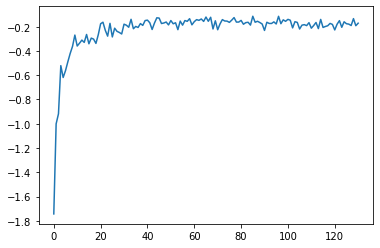

In [77]:
%matplotlib inline

plt.plot(range(len(loss_save)), loss_save)
plt.show